##  Correct Order of Steps for Decision Tree Regression
#### 1.	Handle duplicates & missing values
#### 2.	Treat outliers (using IQR, capping, or transformations)
#### 3.	Apply Target Variable Transformation (If necessary)
#### 4.	Split data into train & test sets
#### 5.	Apply categorical encoding (Only on training data, then transform test data)
#### 6.	Handle multi-collinearity (VIF check, dropping highly correlated features)
#### 7.	Normalize/Standardize numerical features (Only on training data, then transform test data) (Not Necessory for trees)
#### 8.	Train Decision Tree Regression model
#### 9.	Evaluate the model
#### 10. Apply Hyperparameter tuning using Grid search
#### 11. Make final predictions

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error

## Data Import

In [2]:
electric = pd.read_csv(r"C:\Users\HP\Desktop\Python\Machine Learning\Mini Project\Electric vehicles2\archive (2)\train.csv") 

In [3]:
electric.head()

,ID,VIN (1-10),County,City,State,ZIP Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,Expected Price ($1k)
0,EV33174,5YJ3E1EC6L,Snohomish,LYNNWOOD,WA,98037.0,2020.0,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,308,0,32.0,109821694,POINT (-122.287614 47.83874),PUGET SOUND ENERGY INC,50
1,EV40247,JN1AZ0CP8B,Skagit,BELLINGHAM,WA,98229.0,2011.0,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,73,0,40.0,137375528,POINT (-122.414936 48.709388),PUGET SOUND ENERGY INC,15
2,EV12248,WBY1Z2C56F,Pierce,TACOMA,WA,98422.0,2015.0,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,81,0,27.0,150627382,POINT (-122.396286 47.293138),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,18
3,EV55713,1G1RD6E44D,King,REDMOND,WA,98053.0,2013.0,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,38,0,45.0,258766301,POINT (-122.024951 47.670286),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),33.9
4,EV28799,1G1FY6S05K,Pierce,PUYALLUP,WA,98375.0,2019.0,CHEVROLET,BOLT EV,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,0,25.0,296998138,POINT (-122.321062 47.103797),BONNEVILLE POWER ADMINISTRATION||CITY OF TACOM...,41.78


## Data Overview
#### VIN (1-10) - The 1st 10 characters of each vehicle's Vehicle Identification Number (VIN).
#### County- The county in which the registered owner resides.
#### City - The city in which the registered owner resides.
#### State- The state in which the registered owner resides.
#### ZIP Code - The 5-digit zip code in which the registered owner resides.
#### Model Year - The model year of the vehicle is determined by decoding the Vehicle Identification Number (VIN).
#### Make- The manufacturer of the vehicle, determined by decoding the Vehicle Identification Number (VIN).
#### Model- The model of the vehicle is determined by decoding the Vehicle Identification Number (VIN).
#### Electric Vehicle Type - This distinguishes the vehicle as all-electric or a plug-in hybrid.
#### Clean Alternative Fuel Vehicle (CAFV) Eligibility - This categorizes vehicles as Clean Alternative Fuel Vehicles (CAFVs) based on the fuel requirement and electric-only range requirement.
#### Electric Range - Describes how far a vehicle can travel purely on its electric charge.
#### Base MSRP - This is the lowest Manufacturer's Suggested Retail Price (MSRP) for any trim level of the model in question.
#### Legislative District - The specific section of Washington State that the vehicle's owner resides in, as represented in the state legislature.
#### DOL Vehicle ID - Unique number assigned to each vehicle by the Department of Licensing for identification purposes.
#### Vehicle Location - The center of the ZIP Code for the registered vehicle.
#### Electric Utility - This is the electric power retail service territory serving the address of the registered vehicle.
#### Expected Price - This is the expected price of the vehicle.

## Data type

In [4]:
electric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64353 entries, 0 to 64352
Data columns (total 18 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 64353 non-null  object 
 1   VIN (1-10)                                         64353 non-null  object 
 2   County                                             64349 non-null  object 
 3   City                                               64344 non-null  object 
 4   State                                              64342 non-null  object 
 5   ZIP Code                                           64347 non-null  float64
 6   Model Year                                         64346 non-null  float64
 7   Make                                               64349 non-null  object 
 8   Model                                              64340 non-null  object 
 9   Electr

In [5]:
electric['ZIP Code'] = electric['ZIP Code'].astype(str)
electric['Legislative District'] = electric['Legislative District'].astype(str)


In [6]:
electric.describe()

,Model Year,Electric Range,Base MSRP,DOL Vehicle ID
count,64346.000000,64353.000000,64353.000000,6.435300e+04
mean,2018.186212,106.948985,2524.990754,1.972905e+08
std,2.726742,104.093919,12402.895104,1.069466e+08
min,1993.000000,0.000000,0.000000,4.385000e+03
25%,2017.000000,14.000000,0.000000,1.372865e+08
50%,2018.000000,73.000000,0.000000,1.753776e+08
75%,2021.000000,215.000000,0.000000,2.299039e+08
max,2022.000000,337.000000,845000.000000,4.789346e+08


In [7]:
electric = electric.drop(['ID','DOL Vehicle ID','Base MSRP','VIN (1-10)','Vehicle Location'],axis=1)

## Treatment of null values

In [8]:
electric.isnull().sum()

County                                                 4
City                                                   9
State                                                 11
ZIP Code                                               0
Model Year                                             7
Make                                                   4
Model                                                 13
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Legislative District                                   0
Electric Utility                                     722
Expected Price ($1k)                                   0
dtype: int64

In [9]:
electric['Expected Price ($1k)'] = electric['Expected Price ($1k)'].replace('N/',np.nan).astype(float)
electric = electric.dropna(subset=['Expected Price ($1k)'])


In [10]:
electric = electric.fillna(electric.mode().iloc[0])

In [11]:
electric.isnull().sum()

County                                               0
City                                                 0
State                                                0
ZIP Code                                             0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Legislative District                                 0
Electric Utility                                     0
Expected Price ($1k)                                 0
dtype: int64

### Outlier treatment using IQR

<AxesSubplot:>

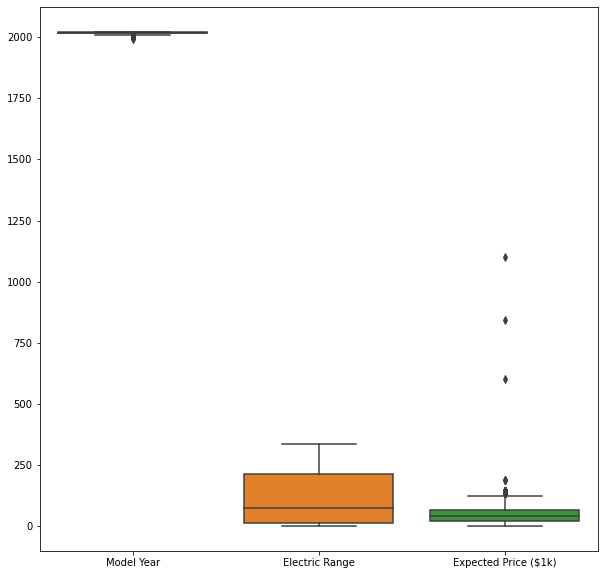

In [12]:
fig, axarr  = plt.subplots(figsize=(10,10))
sns.boxplot(data=electric)

### No outliers are present in 'Electric Range'

## Target Variable Transformation

In [13]:
electric['Expected Price ($1k)'] = np.log1p(electric['Expected Price ($1k)'])

## Splitting the data into training & testing sets.

In [14]:
X = electric.drop(columns=['Expected Price ($1k)'])  # Features
y = electric['Expected Price ($1k)']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Treatment of Numerical columns

#### No need to to Standardization or Normalization as we have only 1 Numerical variable ('Electric Range')

## Treatment of Categorical columns

In [15]:
# Categorical Column types:
# County : Nominal, 140 categories
# City: Nominal, 545 Categories
# State: Nominal, 39 Categories
# ZIP Code: Nominal, 679 Categories
# Make: Nominal, 35 Categories
# Model: Nominal, 107 Categories
# Electric Vehicle Type: Nominal, 2 Categories
# Clean Alternative Fuel Vehicle (CAFV) Eligibility: Nominal, 3 Categories
# Legislative District: Nominal, 51 Categories
# Electric Utility: Nominal, 69 Categories

In [16]:
# Here we have 'Electric Vehicle Type' and 'CAFV Eligibility' where we can apply One-Hot Encoding or Dummies.

low_cardinality_features = ['Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility']

X_train = pd.get_dummies(X_train, columns=low_cardinality_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=low_cardinality_features, drop_first=True)

In [17]:
# To all other variables which have higher number of categories, we can apply Target encoding.
import category_encoders
from category_encoders import TargetEncoder
high_cardinality_features = ['County', 'City', 'State', 'ZIP Code', 'Make', 'Model', 'Legislative District', 'Electric Utility']

target_enc = TargetEncoder()
X_train[high_cardinality_features] = target_enc.fit_transform(X_train[high_cardinality_features], y_train)
X_test[high_cardinality_features] = target_enc.transform(X_test[high_cardinality_features])


## Decision Tree model building

In [18]:
clf = DecisionTreeClassifier(random_state=42) if y.nunique() <= 2 else DecisionTreeRegressor(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

### Model Evaluation

In [19]:
if y.nunique() <= 2:  # Classification
    y_pred = clf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
else:  # Regression
    y_pred = clf.predict(X_test)
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE: 0.02658984587400456


### Hyperparameter Tuning using Grid-search

In [20]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [20, 50, 100],
    'min_samples_leaf': [10, 20, 40],
    'criterion': ['gini', 'entropy'] if y.nunique() <= 2 else ['squared_error', 'friedman_mse']
}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy' if y.nunique() <= 2 else 'neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 20}


### Pruning the Decision Tree

In [21]:
pruned_clf = DecisionTreeClassifier(**grid_search.best_params_, random_state=42) if y.nunique() <= 2 else DecisionTreeRegressor(**grid_search.best_params_, random_state=42)
pruned_clf.fit(X_train, y_train)

DecisionTreeRegressor(min_samples_leaf=10, min_samples_split=20,
                      random_state=42)

### Final Predictions

In [22]:
y_final_pred = pruned_clf.predict(X_test)
print("Final Accuracy:" if y.nunique() <= 2 else "Final RMSE:", accuracy_score(y_test, y_final_pred) if y.nunique() <= 2 else np.sqrt(mean_squared_error(y_test, y_final_pred)))


Final RMSE: 0.04091051467764652
